## Install Dependencies

In [1]:
!pip install -q kaggle datasets spacy transformers
!python -m spacy download en_core_web_lg
!pip install krippendorff
!pip install tqdm
!pip install -q fastcoref
!pip install -q pygraphviz

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 400.7/400.7 MB 2.5 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_lg')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 113.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 97.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 46.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 832.6 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.5

## Import

In [2]:
import torch
import spacy
import pandas as pd
import numpy as np
from tqdm import tqdm
from fastcoref import FCoref
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

## Data Loading

In [4]:
triples_df = pd.read_csv("/content/triples_df.csv")
triples_df.head()

id  text_id                                            context  \
0   0        1       Nobody likes me because I'm not interesting.   
1   1        9   Nobody cares about me because they didn't ask...   
2   2       10   My partner didn't say 'I love you' today our ...   
3   3       12   I didn't get a reply to my email they must ha...   
4   4       23      No one will ever love me because I'm too shy.   

               relationship relation  relation_cluster  \
0  ('like', 'Nobody', 'me')     like                 1   
1  ('care', 'Nobody', 'me')     care                 0   
2      ('love', 'I', 'you')     love                 1   
3    ('hate', 'they', 'me')     hate                 1   
4     ('love', 'one', 'me')     love                 1   

             relation_cluster_label Dominant Distortion  \
0  Interpersonal Beliefs / Emotions  General Distortion   
1                Supportive Actions  General Distortion   
2  Interpersonal Beliefs / Emotions  General Distortion   
3  Interpersonal Beliefs / Emotions  General Distortion   
4  Interpersonal Beliefs / Emotions  General Distortion   

  Secondary Distortion (Optional)  
0                             NaN  
1                             NaN  
2                             NaN  
3                             NaN  
4                             NaN

In [5]:
if torch.cuda.is_available():
  device = torch.device("cuda")
  print(f"{torch.cuda.device_count()} GPU(s) available.")
else:
  print("No GPU available.")
  device = torch.device("cpu")

No GPU available.


## Coreference Resolution & Noun Phrase Extraction from Relation Contexts

In [6]:
# Initialize models
nlp = spacy.load("en_core_web_lg")
coref_model = FCoref()

# Initialize tqdm for pandas
tqdm.pandas()

def resolve_coref(texts):
    try:
        results = coref_model.predict(texts=texts)
        return results
    except Exception as e:
        print(f"Coref error: {str(e)}")
        return texts  # Fallback to original

# Process in batches with progress bar
batch_size = 32
resolved_texts = []
for i in tqdm(range(0, len(triples_df), batch_size),
             desc="Resolving coreferences"):
    batch = triples_df['context'].iloc[i:i+batch_size].tolist()
    resolved_texts.extend(resolve_coref(batch))

triples_df['resolved_context'] = resolved_texts

# Noun extraction
def extract_nouns(text):
    if isinstance(text, str):
        doc = nlp(text)
        return [chunk.text for chunk in doc.noun_chunks if chunk.root.pos_ == "NOUN"]
    else:
        doc = nlp(text.text)
        return [chunk.text for chunk in doc.noun_chunks if chunk.root.pos_ == "NOUN"]


triples_df['context_nouns'] = triples_df['resolved_context'].progress_apply(extract_nouns)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/819 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/393 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/362M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/362M [00:00<?, ?B/s]

Resolving coreferences:   0%|          | 0/104 [00:00<?, ?it/s]

Map:   0%|          | 0/32 [00:00<?, ? examples/s]

Inference:   0%|          | 0/32 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `RobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
Resolving coreferences:   1%|          | 1/104 [00:01<02:14,  1.31s/it]

Map:   0%|          | 0/32 [00:00<?, ? examples/s]

Inference:   0%|          | 0/32 [00:00<?, ?it/s]

Resolving coreferences:   2%|▏         | 2/104 [00:02<01:58,  1.16s/it]

Map:   0%|          | 0/32 [00:00<?, ? examples/s]

Inference:   0%|          | 0/32 [00:00<?, ?it/s]

Resolving coreferences:   3%|▎         | 3/104 [00:03<02:01,  1.20s/it]

Map:   0%|          | 0/32 [00:00<?, ? examples/s]

Inference:   0%|          | 0/32 [00:00<?, ?it/s]

Resolving coreferences:   4%|▍         | 4/104 [00:04<02:03,  1.23s/it]

Map:   0%|          | 0/32 [00:00<?, ? examples/s]

Inference:   0%|          | 0/32 [00:00<?, ?it/s]

Resolving coreferences:   5%|▍         | 5/104 [00:18<09:08,  5.54s/it]

Map:   0%|          | 0/32 [00:00<?, ? examples/s]

Inference:   0%|          | 0/32 [00:00<?, ?it/s]

Resolving coreferences:   6%|▌         | 6/104 [00:36<16:00,  9.80s/it]

Map:   0%|          | 0/32 [00:00<?, ? examples/s]

Inference:   0%|          | 0/32 [00:00<?, ?it/s]

Resolving coreferences:   7%|▋         | 7/104 [00:51<18:53, 11.69s/it]

Map:   0%|          | 0/32 [00:00<?, ? examples/s]

Inference:   0%|          | 0/32 [00:00<?, ?it/s]

Resolving coreferences:   8%|▊         | 8/104 [01:03<18:30, 11.57s/it]

Map:   0%|          | 0/32 [00:00<?, ? examples/s]

Inference:   0%|          | 0/32 [00:00<?, ?it/s]

Resolving coreferences:   9%|▊         | 9/104 [01:14<18:14, 11.52s/it]

Map:   0%|          | 0/32 [00:00<?, ? examples/s]

Inference:   0%|          | 0/32 [00:00<?, ?it/s]

Resolving coreferences:  10%|▉         | 10/104 [01:24<17:24, 11.11s/it]

Map:   0%|          | 0/32 [00:00<?, ? examples/s]

Inference:   0%|          | 0/32 [00:00<?, ?it/s]

Resolving coreferences:  11%|█         | 11/104 [01:39<18:46, 12.11s/it]

Map:   0%|          | 0/32 [00:00<?, ? examples/s]

Inference:   0%|          | 0/32 [00:00<?, ?it/s]

Resolving coreferences:  12%|█▏        | 12/104 [01:50<18:21, 11.97s/it]

Map:   0%|          | 0/32 [00:00<?, ? examples/s]

Inference:   0%|          | 0/32 [00:00<?, ?it/s]

Resolving coreferences:  12%|█▎        | 13/104 [02:08<20:42, 13.66s/it]

Map:   0%|          | 0/32 [00:00<?, ? examples/s]

Inference:   0%|          | 0/32 [00:00<?, ?it/s]

Resolving coreferences:  13%|█▎        | 14/104 [02:21<20:21, 13.58s/it]

Map:   0%|          | 0/32 [00:00<?, ? examples/s]

Inference:   0%|          | 0/32 [00:00<?, ?it/s]

Resolving coreferences:  14%|█▍        | 15/104 [02:30<18:09, 12.24s/it]

Map:   0%|          | 0/32 [00:00<?, ? examples/s]

Inference:   0%|          | 0/32 [00:00<?, ?it/s]

Resolving coreferences:  15%|█▌        | 16/104 [02:42<17:41, 12.06s/it]

Map:   0%|          | 0/32 [00:00<?, ? examples/s]

Inference:   0%|          | 0/32 [00:00<?, ?it/s]

Resolving coreferences:  16%|█▋        | 17/104 [03:07<23:10, 15.99s/it]

Map:   0%|          | 0/32 [00:00<?, ? examples/s]

Inference:   0%|          | 0/32 [00:00<?, ?it/s]

Resolving coreferences:  17%|█▋        | 18/104 [03:24<23:14, 16.22s/it]

Map:   0%|          | 0/32 [00:00<?, ? examples/s]

Inference:   0%|          | 0/32 [00:00<?, ?it/s]

Resolving coreferences:  18%|█▊        | 19/104 [03:46<25:32, 18.03s/it]

Map:   0%|          | 0/32 [00:00<?, ? examples/s]

Inference:   0%|          | 0/32 [00:00<?, ?it/s]

Resolving coreferences:  19%|█▉        | 20/104 [04:10<27:41, 19.78s/it]

Map:   0%|          | 0/32 [00:00<?, ? examples/s]

Inference:   0%|          | 0/32 [00:00<?, ?it/s]

Resolving coreferences:  20%|██        | 21/104 [04:21<23:54, 17.28s/it]

Map:   0%|          | 0/32 [00:00<?, ? examples/s]

Inference:   0%|          | 0/32 [00:00<?, ?it/s]

Resolving coreferences:  21%|██        | 22/104 [04:41<24:40, 18.06s/it]

Map:   0%|          | 0/32 [00:00<?, ? examples/s]

Inference:   0%|          | 0/32 [00:00<?, ?it/s]

Resolving coreferences:  22%|██▏       | 23/104 [04:58<23:57, 17.74s/it]

Map:   0%|          | 0/32 [00:00<?, ? examples/s]

Inference:   0%|          | 0/32 [00:00<?, ?it/s]

Resolving coreferences:  23%|██▎       | 24/104 [05:18<24:19, 18.25s/it]

Map:   0%|          | 0/32 [00:00<?, ? examples/s]

Inference:   0%|          | 0/32 [00:00<?, ?it/s]

Resolving coreferences:  24%|██▍       | 25/104 [05:31<22:04, 16.76s/it]

Map:   0%|          | 0/32 [00:00<?, ? examples/s]

Inference:   0%|          | 0/32 [00:00<?, ?it/s]

Resolving coreferences:  25%|██▌       | 26/104 [05:37<17:34, 13.53s/it]

Map:   0%|          | 0/32 [00:00<?, ? examples/s]

Inference:   0%|          | 0/32 [00:00<?, ?it/s]

Resolving coreferences:  26%|██▌       | 27/104 [05:40<13:22, 10.42s/it]

Map:   0%|          | 0/32 [00:00<?, ? examples/s]

Inference:   0%|          | 0/32 [00:00<?, ?it/s]

Resolving coreferences:  27%|██▋       | 28/104 [05:46<11:35,  9.15s/it]

Map:   0%|          | 0/32 [00:00<?, ? examples/s]

Inference:   0%|          | 0/32 [00:00<?, ?it/s]

Resolving coreferences:  28%|██▊       | 29/104 [05:50<09:26,  7.55s/it]

Map:   0%|          | 0/32 [00:00<?, ? examples/s]

Inference:   0%|          | 0/32 [00:00<?, ?it/s]

Resolving coreferences:  29%|██▉       | 30/104 [05:54<07:53,  6.40s/it]

Map:   0%|          | 0/32 [00:00<?, ? examples/s]

Inference:   0%|          | 0/32 [00:00<?, ?it/s]

Resolving coreferences:  30%|██▉       | 31/104 [06:04<09:07,  7.50s/it]

Map:   0%|          | 0/32 [00:00<?, ? examples/s]

Inference:   0%|          | 0/32 [00:00<?, ?it/s]

Resolving coreferences:  31%|███       | 32/104 [06:08<07:42,  6.43s/it]

Map:   0%|          | 0/32 [00:00<?, ? examples/s]

Inference:   0%|          | 0/32 [00:00<?, ?it/s]

Resolving coreferences:  32%|███▏      | 33/104 [06:14<07:25,  6.28s/it]

Map:   0%|          | 0/32 [00:00<?, ? examples/s]

Inference:   0%|          | 0/32 [00:00<?, ?it/s]

Resolving coreferences:  33%|███▎      | 34/104 [06:27<09:42,  8.33s/it]

Map:   0%|          | 0/32 [00:00<?, ? examples/s]

Inference:   0%|          | 0/32 [00:00<?, ?it/s]

Resolving coreferences:  34%|███▎      | 35/104 [06:51<15:09, 13.18s/it]

Map:   0%|          | 0/32 [00:00<?, ? examples/s]

Inference:   0%|          | 0/32 [00:00<?, ?it/s]

Resolving coreferences:  35%|███▍      | 36/104 [07:09<16:19, 14.40s/it]

Map:   0%|          | 0/32 [00:00<?, ? examples/s]

Inference:   0%|          | 0/32 [00:00<?, ?it/s]

Resolving coreferences:  36%|███▌      | 37/104 [07:19<14:36, 13.08s/it]

Map:   0%|          | 0/32 [00:00<?, ? examples/s]

Inference:   0%|          | 0/32 [00:00<?, ?it/s]

Resolving coreferences:  37%|███▋      | 38/104 [07:31<14:02, 12.77s/it]

Map:   0%|          | 0/32 [00:00<?, ? examples/s]

Inference:   0%|          | 0/32 [00:00<?, ?it/s]

Resolving coreferences:  38%|███▊      | 39/104 [07:46<14:48, 13.67s/it]

Map:   0%|          | 0/32 [00:00<?, ? examples/s]

Inference:   0%|          | 0/32 [00:00<?, ?it/s]

Resolving coreferences:  38%|███▊      | 40/104 [08:14<19:08, 17.94s/it]

Map:   0%|          | 0/32 [00:00<?, ? examples/s]

Inference:   0%|          | 0/32 [00:00<?, ?it/s]

Resolving coreferences:  39%|███▉      | 41/104 [08:46<23:14, 22.14s/it]

Map:   0%|          | 0/32 [00:00<?, ? examples/s]

Inference:   0%|          | 0/32 [00:00<?, ?it/s]

Resolving coreferences:  40%|████      | 42/104 [09:06<22:11, 21.48s/it]

Map:   0%|          | 0/32 [00:00<?, ? examples/s]

Inference:   0%|          | 0/32 [00:00<?, ?it/s]

Resolving coreferences:  41%|████▏     | 43/104 [09:40<25:36, 25.19s/it]

Map:   0%|          | 0/32 [00:00<?, ? examples/s]

Inference:   0%|          | 0/32 [00:00<?, ?it/s]

Resolving coreferences:  42%|████▏     | 44/104 [10:05<25:06, 25.11s/it]

Map:   0%|          | 0/32 [00:00<?, ? examples/s]

Inference:   0%|          | 0/32 [00:00<?, ?it/s]

Resolving coreferences:  43%|████▎     | 45/104 [10:22<22:18, 22.68s/it]

Map:   0%|          | 0/32 [00:00<?, ? examples/s]

Inference:   0%|          | 0/32 [00:00<?, ?it/s]

Resolving coreferences:  44%|████▍     | 46/104 [10:44<21:50, 22.60s/it]

Map:   0%|          | 0/32 [00:00<?, ? examples/s]

Inference:   0%|          | 0/32 [00:00<?, ?it/s]

Resolving coreferences:  45%|████▌     | 47/104 [11:05<21:00, 22.12s/it]

Map:   0%|          | 0/32 [00:00<?, ? examples/s]

Inference:   0%|          | 0/32 [00:00<?, ?it/s]

Resolving coreferences:  46%|████▌     | 48/104 [11:26<20:19, 21.78s/it]

Map:   0%|          | 0/32 [00:00<?, ? examples/s]

Inference:   0%|          | 0/32 [00:00<?, ?it/s]

Resolving coreferences:  47%|████▋     | 49/104 [11:43<18:39, 20.35s/it]

Map:   0%|          | 0/32 [00:00<?, ? examples/s]

Inference:   0%|          | 0/32 [00:00<?, ?it/s]

Resolving coreferences:  48%|████▊     | 50/104 [12:06<18:53, 21.00s/it]

Map:   0%|          | 0/32 [00:00<?, ? examples/s]

Inference:   0%|          | 0/32 [00:00<?, ?it/s]

Resolving coreferences:  49%|████▉     | 51/104 [12:24<17:51, 20.22s/it]

Map:   0%|          | 0/32 [00:00<?, ? examples/s]

Inference:   0%|          | 0/32 [00:00<?, ?it/s]

Resolving coreferences:  50%|█████     | 52/104 [12:43<17:05, 19.73s/it]

Map:   0%|          | 0/32 [00:00<?, ? examples/s]

Inference:   0%|          | 0/32 [00:00<?, ?it/s]

Resolving coreferences:  51%|█████     | 53/104 [13:15<19:48, 23.31s/it]

Map:   0%|          | 0/32 [00:00<?, ? examples/s]

Inference:   0%|          | 0/32 [00:00<?, ?it/s]

Resolving coreferences:  52%|█████▏    | 54/104 [13:31<17:45, 21.32s/it]

Map:   0%|          | 0/32 [00:00<?, ? examples/s]

Inference:   0%|          | 0/32 [00:00<?, ?it/s]

Resolving coreferences:  53%|█████▎    | 55/104 [13:51<16:59, 20.81s/it]

Map:   0%|          | 0/32 [00:00<?, ? examples/s]

Inference:   0%|          | 0/32 [00:00<?, ?it/s]

Resolving coreferences:  54%|█████▍    | 56/104 [14:11<16:29, 20.62s/it]

Map:   0%|          | 0/32 [00:00<?, ? examples/s]

Inference:   0%|          | 0/32 [00:00<?, ?it/s]

Resolving coreferences:  55%|█████▍    | 57/104 [14:25<14:30, 18.51s/it]

Map:   0%|          | 0/32 [00:00<?, ? examples/s]

Inference:   0%|          | 0/32 [00:00<?, ?it/s]

Resolving coreferences:  56%|█████▌    | 58/104 [14:46<14:55, 19.47s/it]

Map:   0%|          | 0/32 [00:00<?, ? examples/s]

Inference:   0%|          | 0/32 [00:00<?, ?it/s]

Resolving coreferences:  57%|█████▋    | 59/104 [15:07<14:51, 19.80s/it]

Map:   0%|          | 0/32 [00:00<?, ? examples/s]

Inference:   0%|          | 0/32 [00:00<?, ?it/s]

Resolving coreferences:  58%|█████▊    | 60/104 [15:24<13:58, 19.06s/it]

Map:   0%|          | 0/32 [00:00<?, ? examples/s]

Inference:   0%|          | 0/32 [00:00<?, ?it/s]

Resolving coreferences:  59%|█████▊    | 61/104 [15:37<12:16, 17.12s/it]

Map:   0%|          | 0/32 [00:00<?, ? examples/s]

Inference:   0%|          | 0/32 [00:00<?, ?it/s]

Resolving coreferences:  60%|█████▉    | 62/104 [15:56<12:21, 17.65s/it]

Map:   0%|          | 0/32 [00:00<?, ? examples/s]

Inference:   0%|          | 0/32 [00:00<?, ?it/s]

Resolving coreferences:  61%|██████    | 63/104 [16:15<12:19, 18.04s/it]

Map:   0%|          | 0/32 [00:00<?, ? examples/s]

Inference:   0%|          | 0/32 [00:00<?, ?it/s]

Resolving coreferences:  62%|██████▏   | 64/104 [16:34<12:21, 18.54s/it]

Map:   0%|          | 0/32 [00:00<?, ? examples/s]

Inference:   0%|          | 0/32 [00:00<?, ?it/s]

Resolving coreferences:  62%|██████▎   | 65/104 [16:52<11:51, 18.23s/it]

Map:   0%|          | 0/32 [00:00<?, ? examples/s]

Inference:   0%|          | 0/32 [00:00<?, ?it/s]

Resolving coreferences:  63%|██████▎   | 66/104 [17:08<11:05, 17.50s/it]

Map:   0%|          | 0/32 [00:00<?, ? examples/s]

Inference:   0%|          | 0/32 [00:00<?, ?it/s]

Resolving coreferences:  64%|██████▍   | 67/104 [17:25<10:51, 17.60s/it]

Map:   0%|          | 0/32 [00:00<?, ? examples/s]

Inference:   0%|          | 0/32 [00:00<?, ?it/s]

Resolving coreferences:  65%|██████▌   | 68/104 [17:49<11:41, 19.49s/it]

Map:   0%|          | 0/32 [00:00<?, ? examples/s]

Inference:   0%|          | 0/32 [00:00<?, ?it/s]

Resolving coreferences:  66%|██████▋   | 69/104 [18:08<11:14, 19.28s/it]

Map:   0%|          | 0/32 [00:00<?, ? examples/s]

Inference:   0%|          | 0/32 [00:00<?, ?it/s]

Resolving coreferences:  67%|██████▋   | 70/104 [18:30<11:25, 20.16s/it]

Map:   0%|          | 0/32 [00:00<?, ? examples/s]

Inference:   0%|          | 0/32 [00:00<?, ?it/s]

Resolving coreferences:  68%|██████▊   | 71/104 [18:55<11:52, 21.60s/it]

Map:   0%|          | 0/32 [00:00<?, ? examples/s]

Inference:   0%|          | 0/32 [00:00<?, ?it/s]

Resolving coreferences:  69%|██████▉   | 72/104 [19:17<11:27, 21.48s/it]

Map:   0%|          | 0/32 [00:00<?, ? examples/s]

Inference:   0%|          | 0/32 [00:00<?, ?it/s]

Resolving coreferences:  70%|███████   | 73/104 [19:39<11:11, 21.66s/it]

Map:   0%|          | 0/32 [00:00<?, ? examples/s]

Inference:   0%|          | 0/32 [00:00<?, ?it/s]

Resolving coreferences:  71%|███████   | 74/104 [19:57<10:22, 20.74s/it]

Map:   0%|          | 0/32 [00:00<?, ? examples/s]

Inference:   0%|          | 0/32 [00:00<?, ?it/s]

Resolving coreferences:  72%|███████▏  | 75/104 [20:21<10:27, 21.63s/it]

Map:   0%|          | 0/32 [00:00<?, ? examples/s]

Inference:   0%|          | 0/32 [00:00<?, ?it/s]

Resolving coreferences:  73%|███████▎  | 76/104 [20:39<09:37, 20.63s/it]

Map:   0%|          | 0/32 [00:00<?, ? examples/s]

Inference:   0%|          | 0/32 [00:00<?, ?it/s]

Resolving coreferences:  74%|███████▍  | 77/104 [21:01<09:26, 20.99s/it]

Map:   0%|          | 0/32 [00:00<?, ? examples/s]

Inference:   0%|          | 0/32 [00:00<?, ?it/s]

Resolving coreferences:  75%|███████▌  | 78/104 [21:22<09:02, 20.86s/it]

Map:   0%|          | 0/32 [00:00<?, ? examples/s]

Inference:   0%|          | 0/32 [00:00<?, ?it/s]

Resolving coreferences:  76%|███████▌  | 79/104 [21:41<08:32, 20.49s/it]

Map:   0%|          | 0/32 [00:00<?, ? examples/s]

Inference:   0%|          | 0/32 [00:00<?, ?it/s]

Resolving coreferences:  77%|███████▋  | 80/104 [22:01<08:09, 20.40s/it]

Map:   0%|          | 0/32 [00:00<?, ? examples/s]

Inference:   0%|          | 0/32 [00:00<?, ?it/s]

Resolving coreferences:  78%|███████▊  | 81/104 [22:48<10:47, 28.14s/it]

Map:   0%|          | 0/32 [00:00<?, ? examples/s]

Inference:   0%|          | 0/32 [00:00<?, ?it/s]

Resolving coreferences:  79%|███████▉  | 82/104 [23:24<11:11, 30.53s/it]

Map:   0%|          | 0/32 [00:00<?, ? examples/s]

Inference:   0%|          | 0/32 [00:00<?, ?it/s]

Resolving coreferences:  80%|███████▉  | 83/104 [23:48<10:03, 28.75s/it]

Map:   0%|          | 0/32 [00:00<?, ? examples/s]

Inference:   0%|          | 0/32 [00:00<?, ?it/s]

Resolving coreferences:  81%|████████  | 84/104 [24:17<09:37, 28.87s/it]

Map:   0%|          | 0/32 [00:00<?, ? examples/s]

Inference:   0%|          | 0/32 [00:00<?, ?it/s]

Resolving coreferences:  82%|████████▏ | 85/104 [24:51<09:34, 30.25s/it]

Map:   0%|          | 0/32 [00:00<?, ? examples/s]

Inference:   0%|          | 0/32 [00:00<?, ?it/s]

Resolving coreferences:  83%|████████▎ | 86/104 [25:22<09:07, 30.44s/it]

Map:   0%|          | 0/32 [00:00<?, ? examples/s]

Inference:   0%|          | 0/32 [00:00<?, ?it/s]

Resolving coreferences:  84%|████████▎ | 87/104 [25:49<08:22, 29.55s/it]

Map:   0%|          | 0/32 [00:00<?, ? examples/s]

Inference:   0%|          | 0/32 [00:00<?, ?it/s]

Resolving coreferences:  85%|████████▍ | 88/104 [26:14<07:28, 28.00s/it]

Map:   0%|          | 0/32 [00:00<?, ? examples/s]

Inference:   0%|          | 0/32 [00:00<?, ?it/s]

Resolving coreferences:  86%|████████▌ | 89/104 [26:33<06:19, 25.29s/it]

Map:   0%|          | 0/32 [00:00<?, ? examples/s]

Inference:   0%|          | 0/32 [00:00<?, ?it/s]

Resolving coreferences:  87%|████████▋ | 90/104 [26:53<05:32, 23.78s/it]

Map:   0%|          | 0/32 [00:00<?, ? examples/s]

Inference:   0%|          | 0/32 [00:00<?, ?it/s]

Resolving coreferences:  88%|████████▊ | 91/104 [27:20<05:21, 24.71s/it]

Map:   0%|          | 0/32 [00:00<?, ? examples/s]

Inference:   0%|          | 0/32 [00:00<?, ?it/s]

Resolving coreferences:  88%|████████▊ | 92/104 [27:45<04:59, 24.95s/it]

Map:   0%|          | 0/32 [00:00<?, ? examples/s]

Inference:   0%|          | 0/32 [00:00<?, ?it/s]

Resolving coreferences:  89%|████████▉ | 93/104 [28:08<04:25, 24.13s/it]

Map:   0%|          | 0/32 [00:00<?, ? examples/s]

Inference:   0%|          | 0/32 [00:00<?, ?it/s]

Resolving coreferences:  90%|█████████ | 94/104 [28:27<03:45, 22.58s/it]

Map:   0%|          | 0/32 [00:00<?, ? examples/s]

Inference:   0%|          | 0/32 [00:00<?, ?it/s]

Resolving coreferences:  91%|█████████▏| 95/104 [28:43<03:06, 20.72s/it]

Map:   0%|          | 0/32 [00:00<?, ? examples/s]

Inference:   0%|          | 0/32 [00:00<?, ?it/s]

Resolving coreferences:  92%|█████████▏| 96/104 [28:57<02:29, 18.63s/it]

Map:   0%|          | 0/32 [00:00<?, ? examples/s]

Inference:   0%|          | 0/32 [00:00<?, ?it/s]

Resolving coreferences:  93%|█████████▎| 97/104 [29:13<02:05, 17.95s/it]

Map:   0%|          | 0/32 [00:00<?, ? examples/s]

Inference:   0%|          | 0/32 [00:00<?, ?it/s]

Resolving coreferences:  94%|█████████▍| 98/104 [29:37<01:58, 19.82s/it]

Map:   0%|          | 0/32 [00:00<?, ? examples/s]

Inference:   0%|          | 0/32 [00:00<?, ?it/s]

Resolving coreferences:  95%|█████████▌| 99/104 [29:56<01:37, 19.53s/it]

Map:   0%|          | 0/32 [00:00<?, ? examples/s]

Inference:   0%|          | 0/32 [00:00<?, ?it/s]

Resolving coreferences:  96%|█████████▌| 100/104 [30:17<01:20, 20.00s/it]

Map:   0%|          | 0/32 [00:00<?, ? examples/s]

Inference:   0%|          | 0/32 [00:00<?, ?it/s]

Resolving coreferences:  97%|█████████▋| 101/104 [30:39<01:02, 20.71s/it]

Map:   0%|          | 0/32 [00:00<?, ? examples/s]

Inference:   0%|          | 0/32 [00:00<?, ?it/s]

Resolving coreferences:  98%|█████████▊| 102/104 [30:57<00:39, 19.73s/it]

Map:   0%|          | 0/32 [00:00<?, ? examples/s]

Inference:   0%|          | 0/32 [00:00<?, ?it/s]

Resolving coreferences:  99%|█████████▉| 103/104 [31:20<00:20, 20.83s/it]

Map:   0%|          | 0/11 [00:00<?, ? examples/s]

Inference:   0%|          | 0/11 [00:00<?, ?it/s]

100%|██████████| 3307/3307 [01:58<00:00, 27.88it/s]


## Semantic Subclustering of Frequent Relation Verbs via Subject-Object Embeddings

In [7]:
# Get top 5 verbs
top_verbs = triples_df['relation'].value_counts().nlargest(5).index.tolist()

# Generate embeddings for subject-object pairs
def get_combined_embedding(row):
    # Extract subject and object from the 'relationship' column
    relationship_tuple = eval(row['relationship']) # Safely evaluate the tuple string
    subject = relationship_tuple[1]
    object_ = relationship_tuple[2] # Use object_ to avoid conflict with built-in object

    # Ensure resolved_context is a string
    resolved_context_text = row['resolved_context'].text if hasattr(row['resolved_context'], 'text') else row['resolved_context']

    subject_doc = nlp(subject)
    object_doc = nlp(object_)
    return np.concatenate([subject_doc.vector, object_doc.vector])

triples_df['so_embedding'] = triples_df.progress_apply(get_combined_embedding, axis=1)

# Subcluster each verb
subcluster_labels = {}
optimal_clusters = {}

# Initialize a list to store subcluster IDs for all rows
all_subcluster_ids = pd.Series(index=triples_df.index, dtype=object)

for verb in top_verbs:
    verb_indices = triples_df[triples_df['relation'] == verb].index # Use relation_text for verb
    verb_df = triples_df.loc[verb_indices].copy()

    if len(verb_df) < 3:
        continue

    embeddings = np.stack(verb_df['so_embedding'].values)
    scaler = StandardScaler()
    scaled_embeddings = scaler.fit_transform(embeddings)

    # Determine optimal cluster count (2-5)
    best_score = -1
    best_k = 2

    for k in range(2, min(6, len(verb_df))):
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        clusters = kmeans.fit_predict(scaled_embeddings)
        # Check if there's more than one cluster before calculating silhouette score
        if len(np.unique(clusters)) > 1:
            score = silhouette_score(scaled_embeddings, clusters)
            if score > best_score:
                best_score = score
                best_k = k
        else:
            # If only one cluster, silhouette score is undefined or not meaningful
            score = -1 # Assign a low score

    # Store optimal k
    optimal_clusters[verb] = best_k

    # Cluster with optimal k and store in the main dataframe
    kmeans = KMeans(n_clusters=best_k, random_state=42, n_init=10)
    clusters = kmeans.fit_predict(scaled_embeddings)
    triples_df.loc[verb_indices, 'subcluster_id'] = clusters.astype(int)


    # Create descriptive labels
    cluster_labels = {}
    for cluster_id in range(best_k):
        cluster_df = verb_df[clusters == cluster_id]

        # Get most common relationship types
        if not cluster_df.empty:
            top_types = cluster_df['relation_cluster_label'].value_counts().index.tolist()
            label = f"{verb} ({top_types[0]})" if top_types else f"{verb} (general)"
            cluster_labels[cluster_id] = label

    # Store results
    subcluster_labels[verb] = cluster_labels

    for cluster_id, label in cluster_labels.items():
        triples_df.loc[verb_indices[clusters == cluster_id], 'subcluster'] = label

triples_df['subcluster'] = triples_df['subcluster'].fillna(triples_df['relation'] + " (general)") # Use relation_text
triples_df['subcluster_id'] = triples_df['subcluster_id'].astype('Int64')

100%|██████████| 3307/3307 [00:34<00:00, 95.12it/s] 


## Visualizing Verb Subclusters: Silhouette Score and PCA Embeddings

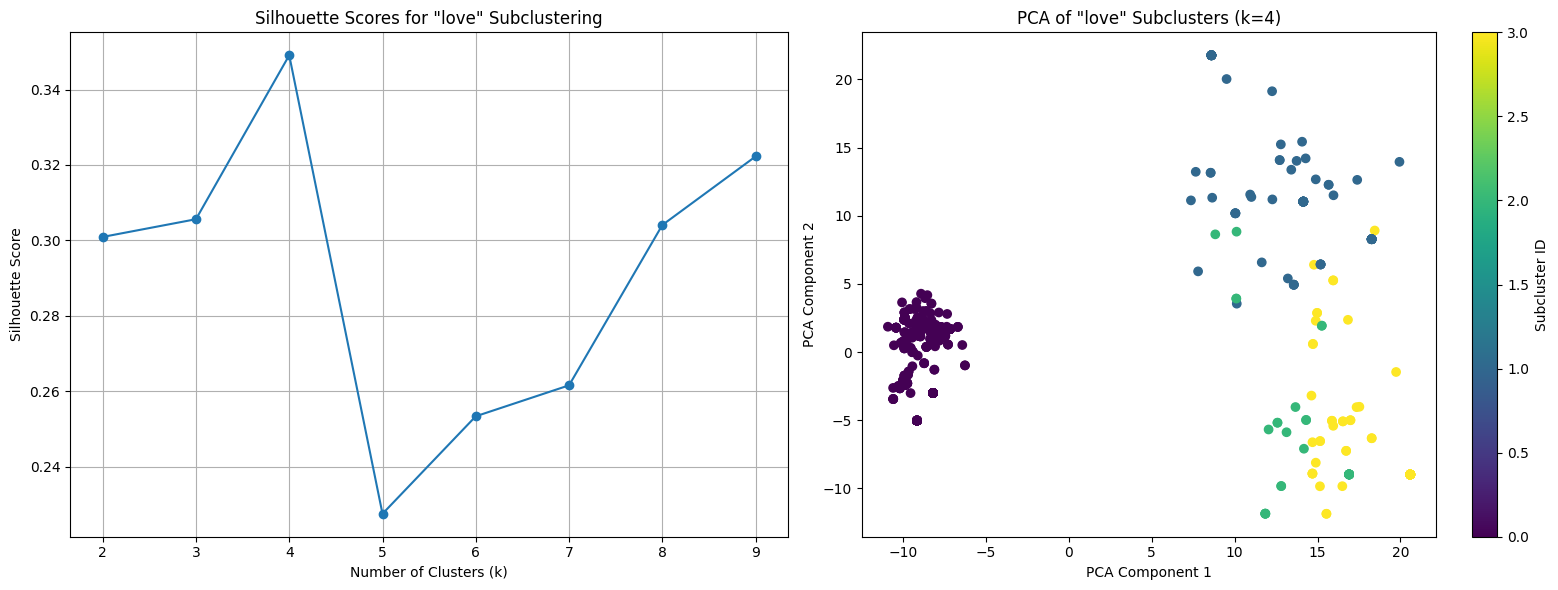

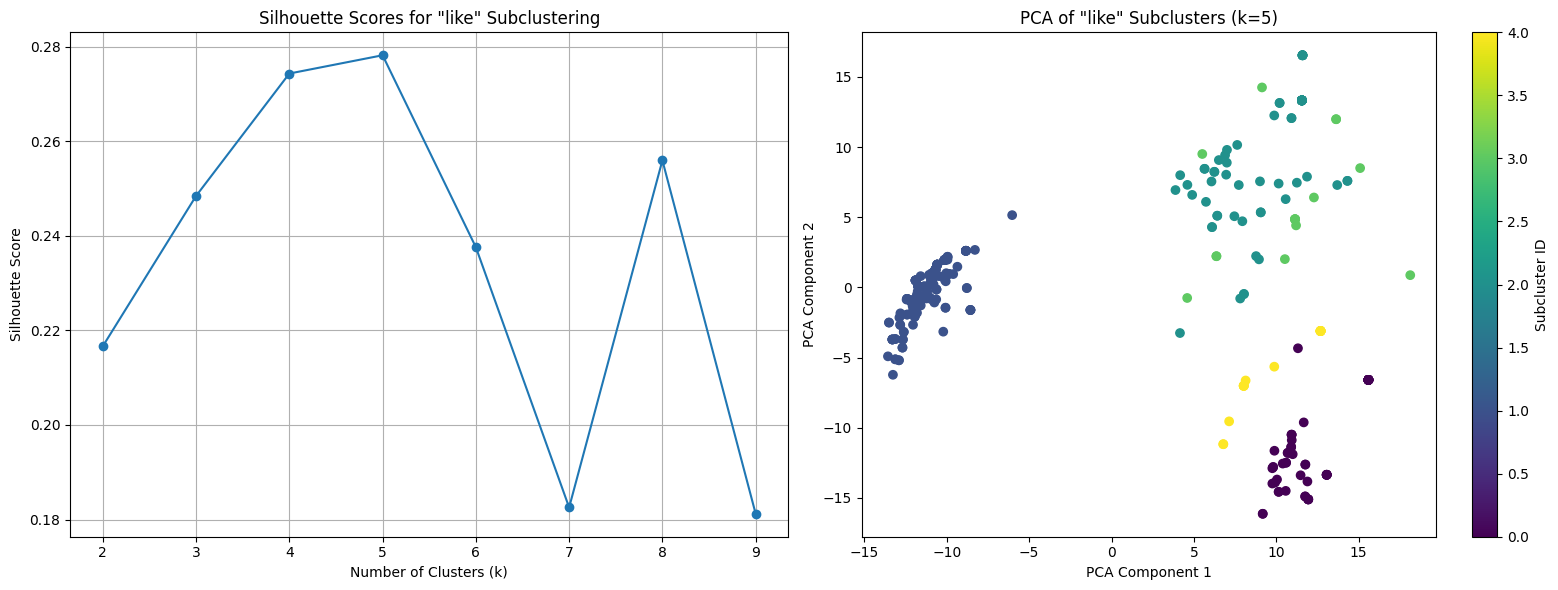

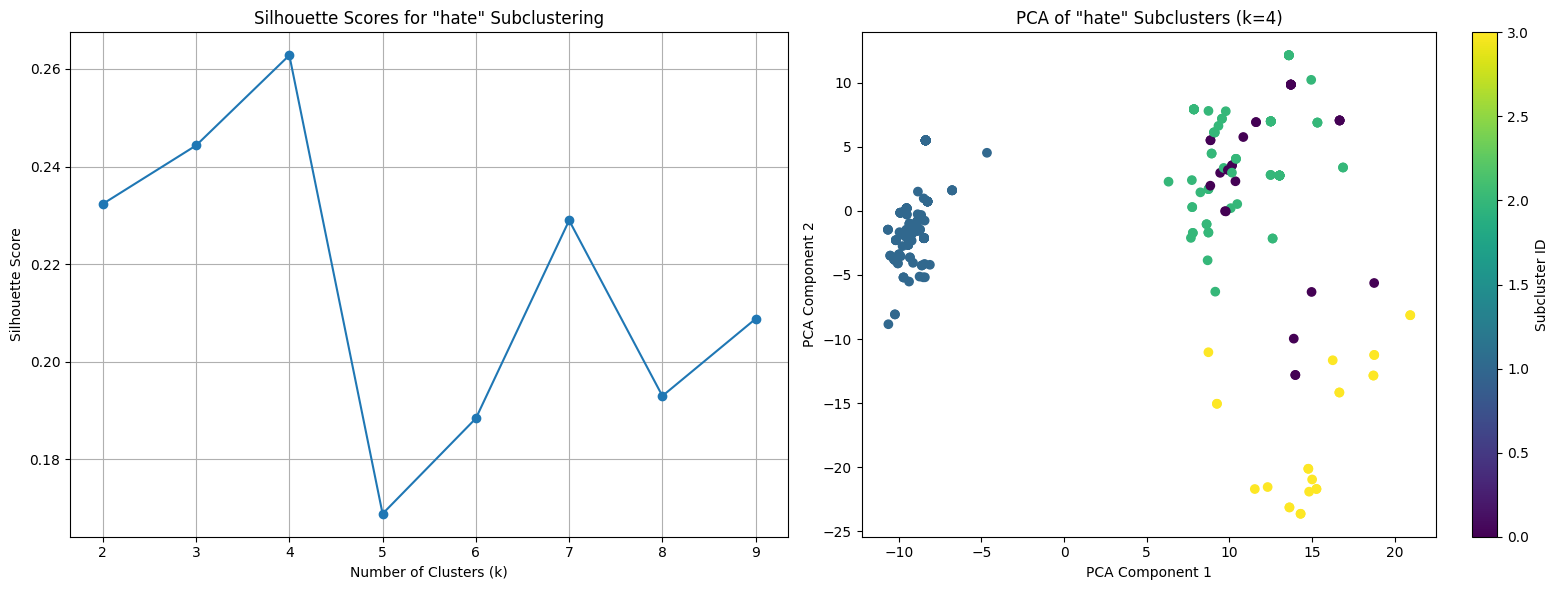

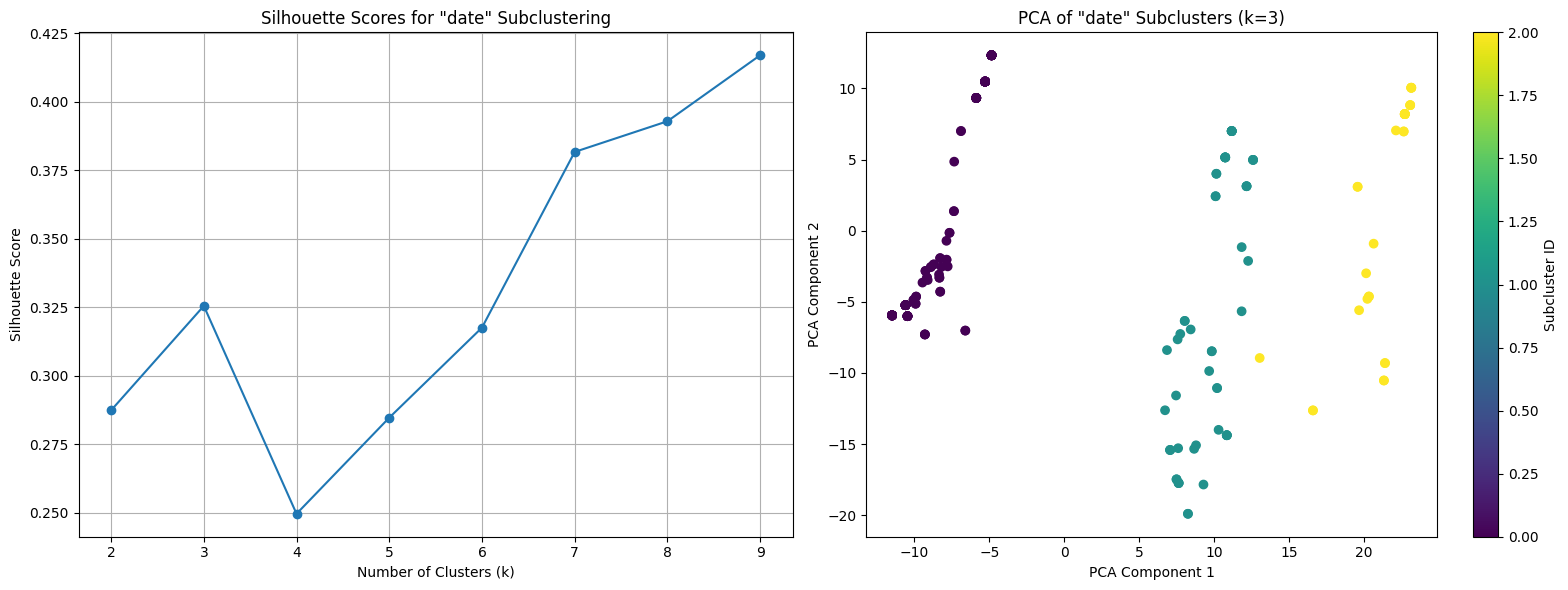

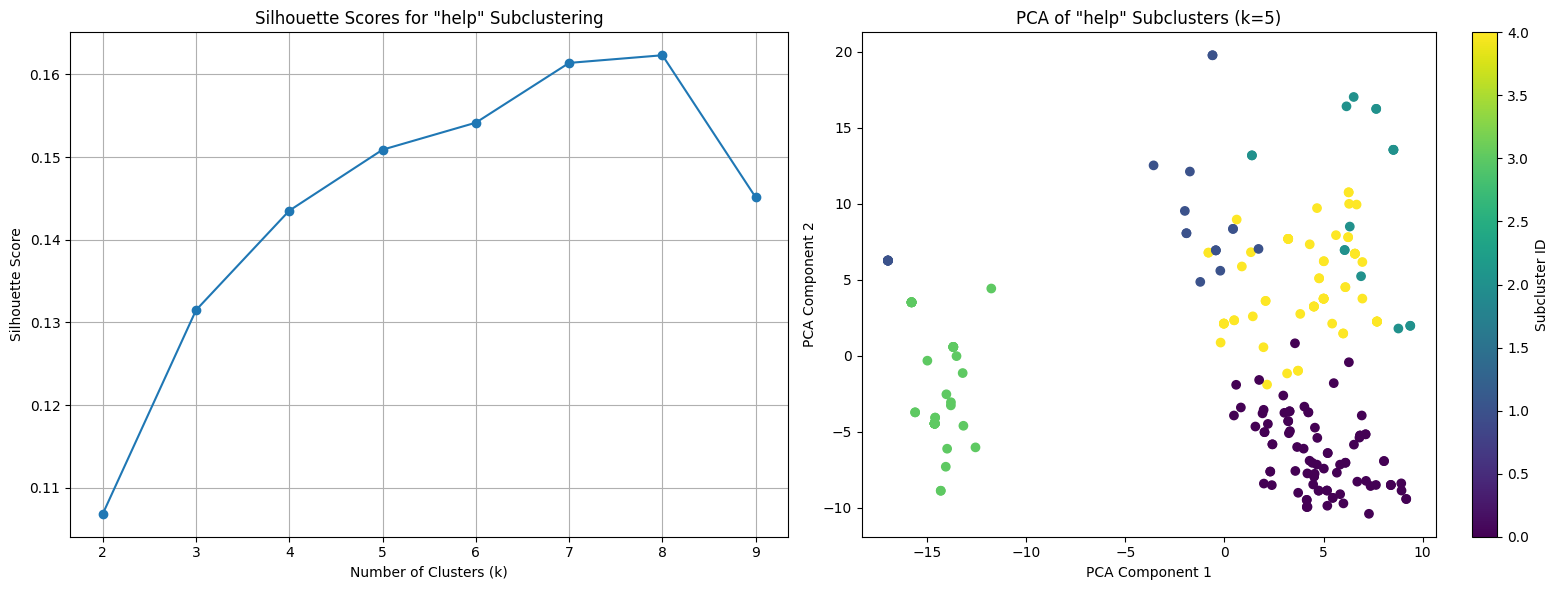

In [8]:
for verb, optimal_k in optimal_clusters.items():
    verb_indices = triples_df[triples_df['relation'] == verb].index
    verb_df = triples_df.loc[verb_indices].copy()

    if len(verb_df) < 3:
        continue

    embeddings = np.stack(verb_df['so_embedding'].values)
    scaler = StandardScaler()
    scaled_embeddings = scaler.fit_transform(embeddings)

    # Silhouette Score Plot
    silhouette_scores_list = []
    k_range = range(2, min(10, len(verb_df)))

    for k in k_range:
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        clusters = kmeans.fit_predict(scaled_embeddings)
        score = silhouette_score(scaled_embeddings, clusters)
        silhouette_scores_list.append(score)

    # PCA Plot
    if scaled_embeddings.shape[1] > 2:
        pca = PCA(n_components=2)
        pca_embeddings = pca.fit_transform(scaled_embeddings)
    else:
        pca_embeddings = scaled_embeddings

    # Get the cluster assignments for this verb (ensure they exist)
    if optimal_k is not None and optimal_k >= 2:
        kmeans_final = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
        verb_clusters = kmeans_final.fit_predict(scaled_embeddings)
    else:
        verb_clusters = np.zeros(len(verb_df))

    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    # Plot Silhouette Scores on the first subplot
    axes[0].plot(k_range, silhouette_scores_list, marker='o')
    axes[0].set_title(f'Silhouette Scores for "{verb}" Subclustering')
    axes[0].set_xlabel('Number of Clusters (k)')
    axes[0].set_ylabel('Silhouette Score')
    axes[0].set_xticks(k_range)
    axes[0].grid(True)

    # Plot PCA on the second subplot
    scatter = axes[1].scatter(pca_embeddings[:, 0], pca_embeddings[:, 1], c=verb_clusters, cmap='viridis')
    axes[1].set_title(f'PCA of "{verb}" Subclusters (k={optimal_k})')
    axes[1].set_xlabel('PCA Component 1')
    axes[1].set_ylabel('PCA Component 2')
    fig.colorbar(scatter, ax=axes[1], label='Subcluster ID')

    plt.tight_layout()
    plt.show()

## Optimal number of clusters found for each of the top 5 verbs


In [9]:
print("Optimal number of clusters for each top relation:")
for verb, k in optimal_clusters.items():
    print(f"'{verb}': {k} clusters")


Optimal number of clusters for each top relation:
'love': 4 clusters
'like': 5 clusters
'hate': 4 clusters
'date': 3 clusters
'help': 5 clusters


## Exploring Verb Subclusters and their Contexts

In [10]:
for verb in top_verbs:
    print(f"Verb: {verb}")
    if verb in subcluster_labels:
        # Sort cluster IDs numerically
        sorted_cluster_ids = sorted(subcluster_labels[verb].keys())
        for cluster_id in sorted_cluster_ids:
            cluster_data = triples_df[(triples_df['relation'] == verb) & (triples_df['subcluster_id'] == cluster_id)]
            original_indices = cluster_data.index.tolist()
            context_texts = triples_df.loc[original_indices, 'context'].tolist()
            print(f"Cluster {cluster_id}: {context_texts}")
    else:
        print(f"No subclusters found for verb: {verb}")

Verb: love
Cluster 0: [" My partner didn't say 'I love you' today our relationship must be falling apart.", " My partner didn't say 'I love you' today they must not love me anymore.", " My girlfriend didn't say 'I love you' back she must not love me.", " My partner didn't say 'I love you' today they must not love me anymore.", " My girlfriend didn't say 'I love you' back she must not love me.", " My partner didn't say 'I love you' today they must not care about me anymore.", ' So I’ve been dating on and off this guy for almost 3 years He is 3 years younger than me During our relationship we had always had issues First he wouldn’t call me he would prefer to go out with his friends than me he wouldn’t even remember the day of our anniversary or things like that we kind of tried to work all that out but I’ve always felt that he really doesn’t love and care about me even though he says he loves me Also he has lied to me during this time first once he went to a party and when I asked him if

## Mapping Subclusters to Descriptive Labels

In [15]:
label_mapping = {
    ('love', 0): 'love (general)',
    ('love', 1): 'love (insecurity)',
    ('love', 2): 'love (affirmation and doubt)',
    ('love', 3): 'love (romantic doubt)',
    ('like', 0): 'like (social/familial)',
    ('like', 1): 'like (personal preference)',
    ('like', 2): 'like (external validation)',
    ('like', 3): 'like (relationship doubt)',
    ('like', 4): 'like (explicit dislike)',
    ('hate', 0): 'hate (others)',
    ('hate', 1): 'hate (self-loathing)',
    ('hate', 2): 'hate (feeling hated)',
    ('hate', 3): 'hate (complex dynamics)',
    ('date', 0): 'date (general experiences)',
    ('date', 1): 'date (long-term challenges)',
    ('date', 2): 'date (duration and breaks)',
    ('help', 0): 'help (personal issues)',
    ('help', 1): 'help (supporting others)',
    ('help', 2): 'help (effectiveness doubts)',
    ('help', 3): 'help (self vs. others)',
    ('help', 4): 'help (feeling unhelped)'
}

triples_df['subcluster_label'] = triples_df.apply(
    lambda row: label_mapping.get((row['relation'], row['subcluster_id']), f"{row['relation']} (unlabeled cluster {row['subcluster_id']})")
    if pd.notna(row['subcluster_id']) else f"{row['relation']} (general)", # Handle rows without a subcluster_id
    axis=1
)

# Display the updated DataFrame with the new label column
print(triples_df[['relation', 'subcluster_id', 'subcluster_label']].head())

# You can also verify by printing some examples
for verb in top_verbs:
    print(f"\nExamples for Verb: {verb}")
    verb_df = triples_df[triples_df['relation'] == verb]
    if not verb_df.empty:
        print(verb_df[['subcluster_id', 'subcluster_label']].drop_duplicates().sort_values('subcluster_id'))
    else:
        print("No data for this verb.")

  relation  subcluster_id            subcluster_label
0     like              2  like (external validation)
1     care           <NA>              care (general)
2     love              0              love (general)
3     hate              2        hate (feeling hated)
4     love              1           love (insecurity)

Examples for Verb: love
    subcluster_id              subcluster_label
2               0                love (general)
4               1             love (insecurity)
60              2  love (affirmation and doubt)
39              3         love (romantic doubt)

Examples for Verb: like
     subcluster_id            subcluster_label
100              0      like (social/familial)
188              1  like (personal preference)
0                2  like (external validation)
63               3   like (relationship doubt)
245              4     like (explicit dislike)

Examples for Verb: hate
     subcluster_id         subcluster_label
314              0            hate 

## Dimensionality Reduction Analysis of Verb Embeddings

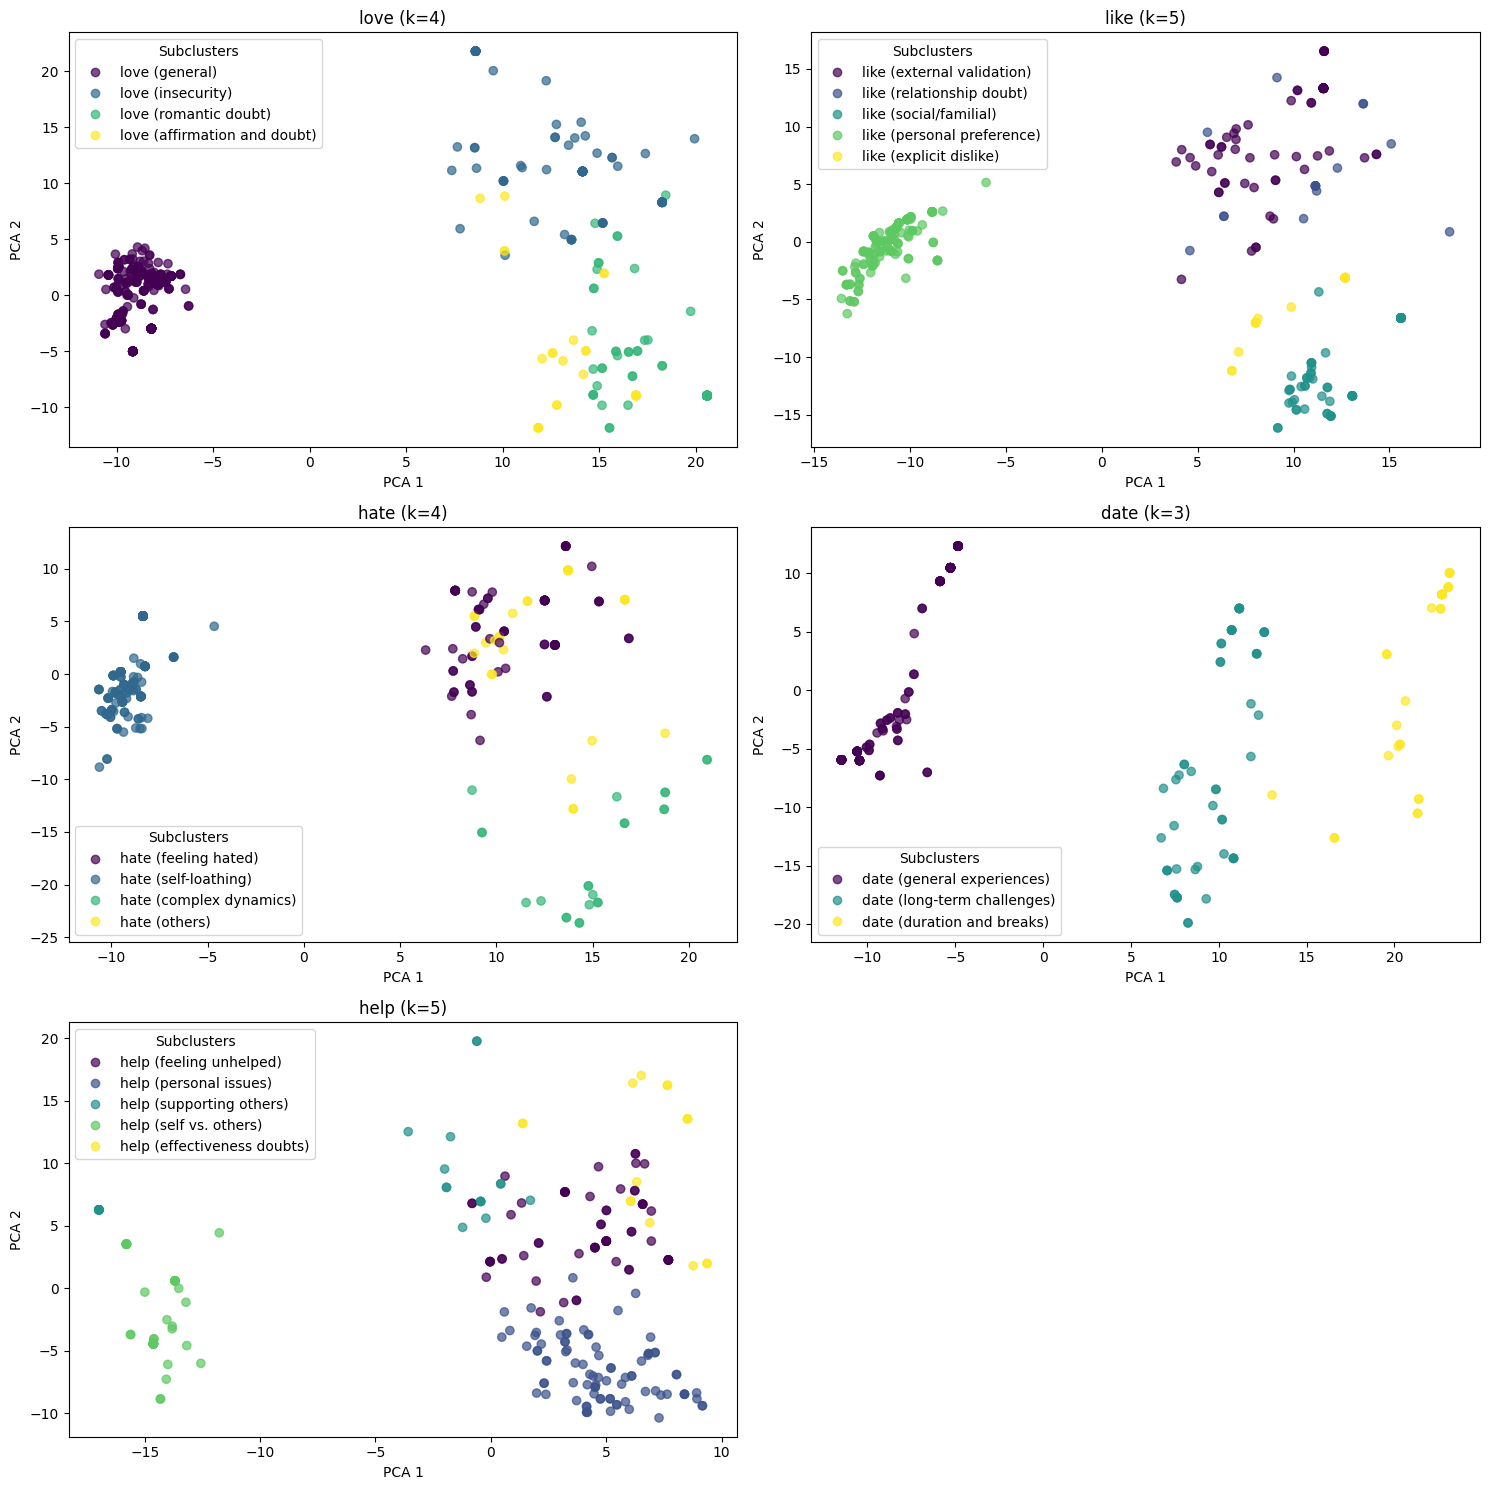

In [16]:
n_verbs = len(top_verbs)
n_cols = 2
n_rows = (n_verbs + n_cols - 1) // n_cols

fig, axs = plt.subplots(n_rows, n_cols, figsize=(15, n_rows * 5))

# Flatten axs if it's a 2D array for easier iteration
if n_rows > 1:
    axs = axs.flatten()
else:
    axs = [axs]

for i, verb in enumerate(top_verbs):
    if verb not in optimal_clusters:
        if i < len(axs):
            fig.delaxes(axs[i])
        continue

    verb_df = triples_df[triples_df['relation'] == verb].copy()
    if len(verb_df) < 2:
        if i < len(axs):
            fig.delaxes(axs[i])
        continue


    embeddings = np.stack(verb_df['so_embedding'].values)
    scaler = StandardScaler()
    scaled_embeddings = scaler.fit_transform(embeddings)

    # Reduce dimensionality for visualization
    pca = PCA(n_components=2)
    coords = pca.fit_transform(scaled_embeddings)

    ax = axs[i]
    unique_labels = verb_df['subcluster_label'].unique()
    label_to_int = {label: j for j, label in enumerate(unique_labels)}
    colors = verb_df['subcluster_label'].map(label_to_int)

    scatter = ax.scatter(coords[:, 0], coords[:, 1],
                         c=colors,
                         cmap='viridis', alpha=0.7)
    ax.set_title(f'{verb} (k={optimal_clusters[verb]})')
    ax.set_xlabel('PCA 1')
    ax.set_ylabel('PCA 2')

    handles, _ = scatter.legend_elements()
    ax.legend(handles, unique_labels, title="Subclusters")
for j in range(i + 1, len(axs)):
    fig.delaxes(axs[j])
plt.tight_layout()
plt.show()

## Correlation Analysis with Cramer's V

In [17]:
from scipy.stats import chi2_contingency

def cramers_v(contingency_table):
    """Calculate Cramer's V for categorical-categorical association."""
    chi2, _, _, _ = chi2_contingency(contingency_table)
    n = contingency_table.sum().sum()
    phi2 = chi2 / n
    r, k = contingency_table.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))

# Prepare analysis for each verb's subclusters
results = []
for verb in triples_df['relation'].unique():
    verb_df = triples_df[triples_df['relation'] == verb]

    # Skip verbs with <2 subclusters or no distortion variation
    if len(verb_df['subcluster_label'].unique()) < 2 or len(verb_df['Dominant Distortion'].unique()) < 2:
        continue

    # Create contingency table: subclusters × distortions
    contingency = pd.crosstab(
        verb_df['subcluster_label'],
        verb_df['Dominant Distortion']
    )

    # Calculate Cramer's V and significance
    v = cramers_v(contingency.values)
    chi2, p, _, _ = chi2_contingency(contingency.values)

    results.append({
        'verb': verb,
        'n_subclusters': len(verb_df['subcluster_label'].unique()),
        'cramers_v': v,
        'p_value': p,
        'contingency_table': contingency
    })

# Sort results by Cramer's V (strongest associations first)
results_sorted = sorted(results, key=lambda x: x['cramers_v'], reverse=True)

# Display results
print("="*50)
print("Subcluster-Distortion Association Analysis")
print("="*50 + "\n")

for res in results_sorted:
    print(f"\nVerb: {res['verb'].upper()} ({res['n_subclusters']} subclusters)")
    print(f"Cramer's V: {res['cramers_v']:.3f} | p-value: {res['p_value']:.4f}")

    # Print interpretation
    if res['cramers_v'] >= 0.4:
        strength = "STRONG association"
    elif res['cramers_v'] >= 0.2:
        strength = "Moderate association"
    else:
        strength = "Weak/no association"
    print(f"Interpretation: {strength}")

    # Display top 3 strongest subcluster-distortion pairs
    norm_table = res['contingency_table'].div(res['contingency_table'].sum(1), axis=0)
    top_pairs = norm_table.stack().sort_values(ascending=False).head(3)

    print("\nTop Subcluster-Distortion Pairs:")
    for (subcluster, distortion), ratio in top_pairs.items():
        print(f"- {subcluster}: {distortion} ({ratio:.1%})")

    print("\n" + "-"*50)

Subcluster-Distortion Association Analysis


Verb: LIKE (5 subclusters)
Cramer's V: 0.244 | p-value: 0.0000
Interpretation: Moderate association

Top Subcluster-Distortion Pairs:
- like (explicit dislike): No Distortion (60.0%)
- like (social/familial): No Distortion (59.0%)
- like (relationship doubt): General Distortion (43.8%)

--------------------------------------------------

Verb: HATE (4 subclusters)
Cramer's V: 0.221 | p-value: 0.0000
Interpretation: Moderate association

Top Subcluster-Distortion Pairs:
- hate (complex dynamics): No Distortion (41.7%)
- hate (feeling hated): No Distortion (32.1%)
- hate (others): No Distortion (31.0%)

--------------------------------------------------

Verb: DATE (3 subclusters)
Cramer's V: 0.215 | p-value: 0.0031
Interpretation: Moderate association

Top Subcluster-Distortion Pairs:
- date (general experiences): No Distortion (60.6%)
- date (long-term challenges): No Distortion (50.0%)
- date (duration and breaks): No Distortion (48.5%)

--

## Visualizing Correlation Results

## 1. Overall Cramer's V (Verb-Level) ##


/tmp/ipython-input-1745781937.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


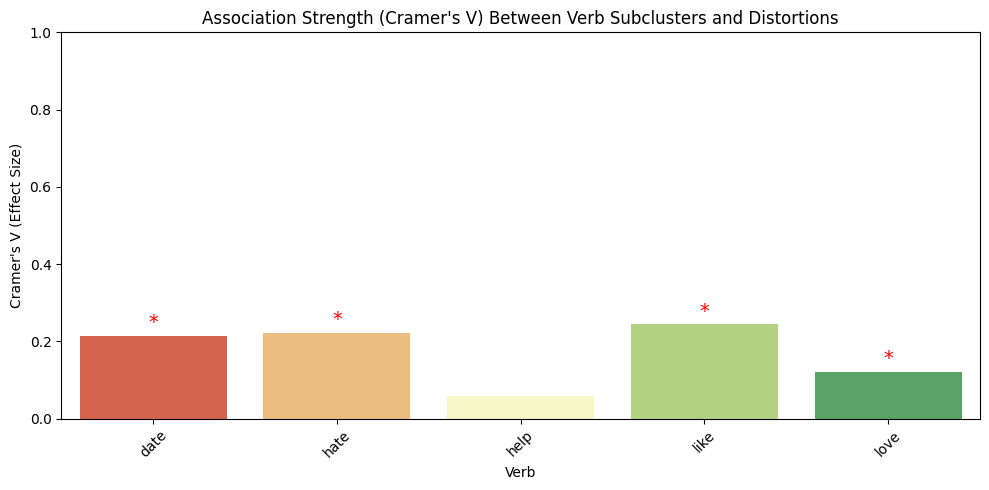


## 2. Detailed Subcluster Patterns (Top 2 + Love and Help) ##


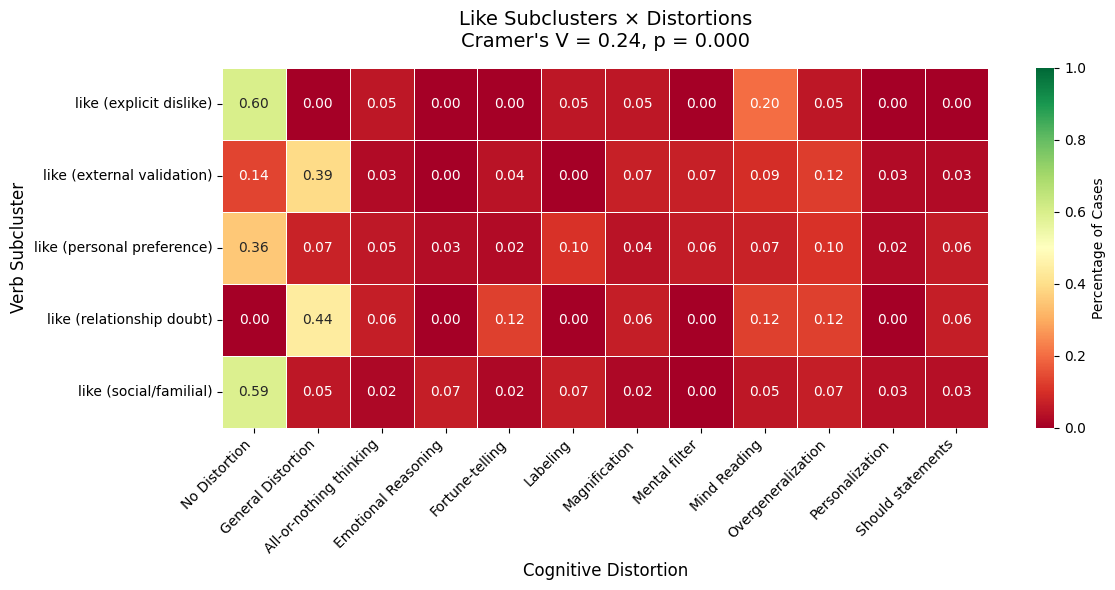

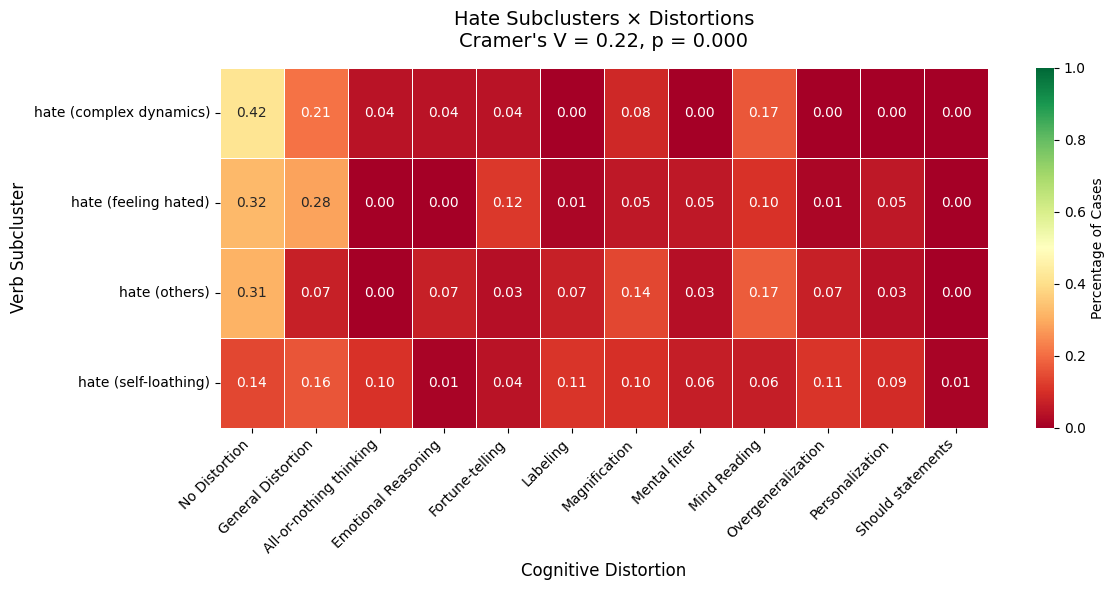

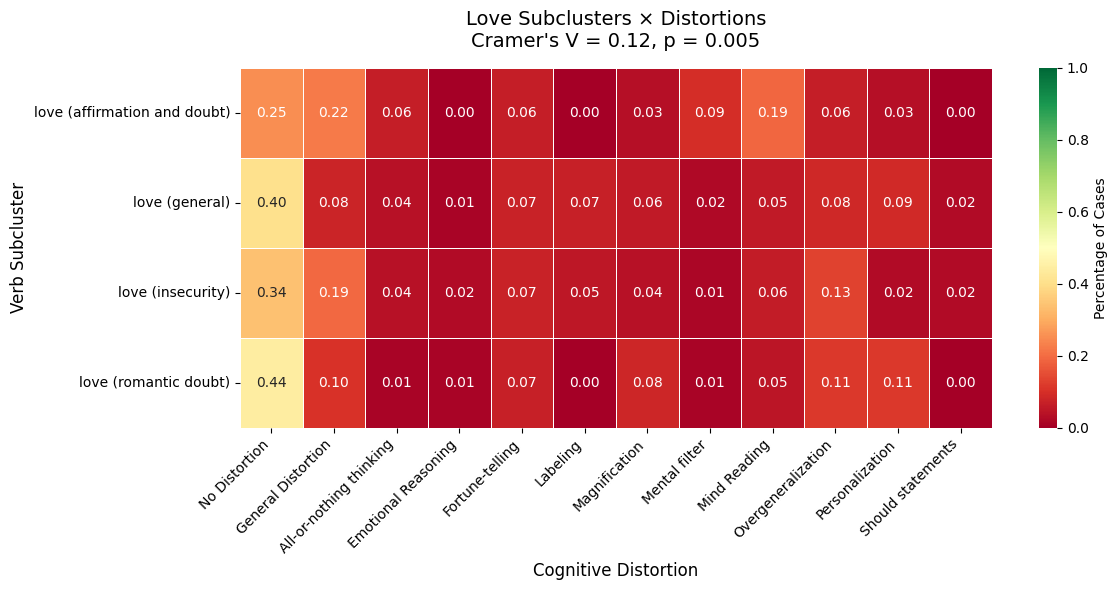

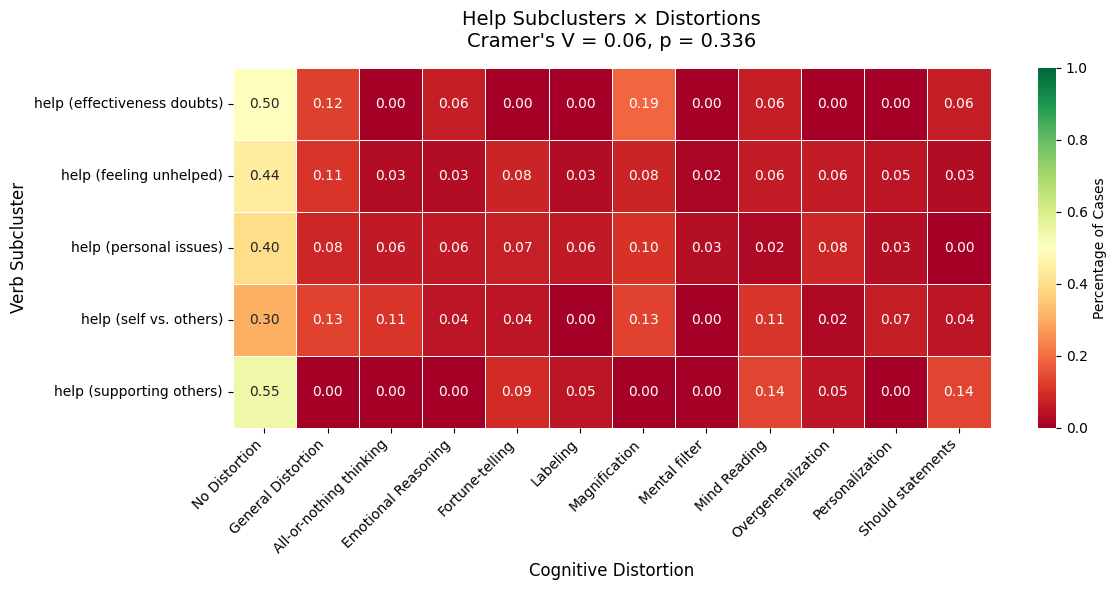

In [18]:
# ----- Custom Sort Function for Distortions -----
def custom_distortion_sort(distortions):
    return sorted(distortions, key=lambda x: (
        0 if str(x).startswith("No ") else (1 if str(x).startswith("General ") else 2), x
    ))

# ----- 1. Heatmap of Cramer's V Scores per Verb -----
def plot_cramersv_bar(results):
    df = pd.DataFrame({
        'Verb': [res['verb'] for res in results],
        'Cramer_V': [res['cramers_v'] for res in results],
        'p_value': [res['p_value'] for res in results]
    }).sort_values('Verb')  # alphabetically sorted

    plt.figure(figsize=(10, 5))
    ax = sns.barplot(
        data=df,
        x='Verb',
        y='Cramer_V',
        palette='RdYlGn',
        dodge=False
    )

    for i, p in enumerate(df['p_value']):
        if p < 0.05:
            ax.text(i, df['Cramer_V'].iloc[i] + 0.02, "*", ha='center', fontsize=14, color='red')

    plt.title("Association Strength (Cramer's V) Between Verb Subclusters and Distortions")
    plt.ylabel("Cramer's V (Effect Size)")
    plt.ylim(0, 1)
    plt.xlabel("Verb")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# ----- 2. Subcluster × Distortion Heatmaps (Top N Verbs + Love and Help) -----
def plot_subcluster_heatmaps(results, n_top=2):
    top_results = sorted(results, key=lambda x: x['cramers_v'], reverse=True)[:n_top]

    # Add 'love' and 'help' results if they are not already in top_results
    verbs_to_plot = [res['verb'] for res in top_results]
    for res in results:
        if res['verb'] in ['love', 'help'] and res['verb'] not in verbs_to_plot:
            top_results.append(res)
            verbs_to_plot.append(res['verb'])

    for res in top_results:
        df = res['contingency_table']

        # Normalize
        norm_df = df.div(df.sum(1), axis=0)

        # Sort
        sorted_index = sorted(norm_df.index)
        sorted_columns = custom_distortion_sort(norm_df.columns)

        plt.figure(figsize=(12, 6))
        sns.heatmap(
            norm_df.loc[sorted_index, sorted_columns],
            cmap='RdYlGn',
            vmin=0.0,
            vmax=1.0,
            annot=True,
            fmt=".2f",
            linewidths=0.5,
            cbar_kws={"label": "Percentage of Cases"}
        )
        plt.title(
            f"{res['verb'].title()} Subclusters × Distortions\nCramer's V = {res['cramers_v']:.2f}, p = {res['p_value']:.3f}",
            fontsize=14, pad=15
        )
        plt.xlabel("Cognitive Distortion", fontsize=12)
        plt.ylabel("Verb Subcluster", fontsize=12)
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.show()

# ----- 3. Bar Plot of Top Subcluster–Distortion Associations -----
def plot_top_associations(results, n=5):
    associations = []
    for res in results:
        norm_table = res['contingency_table'].div(res['contingency_table'].sum(1), axis=0)
        for sub in norm_table.index:
            for dist in norm_table.columns:
                associations.append({
                    'Verb': res['verb'],
                    'Subcluster': sub,
                    'Distortion': dist,
                    'Percentage': norm_table.loc[sub, dist]
                })

    top_df = pd.DataFrame(associations).sort_values('Percentage', ascending=False).head(n)

    # Sort distortions
    top_df['Distortion'] = pd.Categorical(
        top_df['Distortion'],
        categories=custom_distortion_sort(top_df['Distortion'].unique()),
        ordered=True
    )

    plt.figure(figsize=(10, 5))
    sns.barplot(
        data=top_df,
        x='Percentage',
        y='Subcluster',
        hue='Distortion',
        palette='RdYlGn',
        dodge=False
    )
    plt.title(f"Top {n} Subcluster–Distortion Associations")
    plt.xlabel("Percentage of Cases")
    plt.xlim(0, 1)
    plt.ylabel("Subcluster")
    plt.legend(title='Distortion', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

# ----- Call All Plots -----
print("## 1. Overall Cramer's V (Verb-Level) ##")
plot_cramersv_bar(results)

print("\n## 2. Detailed Subcluster Patterns (Top 2 + Love and Help) ##")
plot_subcluster_heatmaps(results, n_top=2)

## measuring agreement between subclusters and distortion categories (Krippendorff’s Alpha, Fleiss' Kappa, Pearson Correlation)

In [19]:
from krippendorff import alpha as kripp_alpha
from sklearn.metrics import cohen_kappa_score
from scipy.stats import pearsonr

# Define your top 5 relations and distortion columns
relation_cols = ['love', 'like', 'hate', 'date', 'help']
distortions = triples_df['Dominant Distortion'].unique()

# Filter dataframe to only include top 5 verbs
filtered_df = triples_df[triples_df['relation'].isin(relation_cols)]

records = []
for verb in relation_cols:
    verb_df = filtered_df[filtered_df['relation'] == verb]
    subclusters = verb_df['subcluster_label'].dropna().unique()

    for sc in subclusters:
        vec_sc = (filtered_df['subcluster_label'] == sc).astype(int)

        # Skip underrepresented subclusters
        if vec_sc.sum() < 2:
            continue

        for dist in distortions:
            vec_dist = (filtered_df['Dominant Distortion'] == dist).astype(int)

            # Skip rare distortion cases
            if vec_dist.sum() < 1:
                continue

            # Krippendorff’s Alpha
            try:
                data = np.vstack([vec_sc.values, vec_dist.values])
                k_alpha = kripp_alpha(data, level_of_measurement='nominal')
            except Exception:
                k_alpha = np.nan

            # Fleiss’ Kappa via Cohen's Kappa
            try:
                kappa = cohen_kappa_score(vec_sc, vec_dist)
            except Exception:
                kappa = np.nan

            # Pearson R
            try:
                r, _ = pearsonr(vec_sc, vec_dist)
            except Exception:
                r = np.nan

            records.append({
                'verb': verb,
                'subcluster': sc,
                'distortion': dist,
                'kripp_alpha': k_alpha,
                'fleiss_kappa': kappa,
                'pearson_r': r
            })

# Build final DataFrame
agreement_df = pd.DataFrame.from_records(records)

# Pivot tables
alpha_pivot = agreement_df.pivot(index='distortion', columns= 'subcluster', values='kripp_alpha')
kappa_pivot = agreement_df.pivot(index='distortion', columns= 'subcluster', values='fleiss_kappa')
pearson_pivot = agreement_df.pivot(index='distortion', columns= 'subcluster', values='pearson_r')

# Display pivot tables (rounded for clarity)
print("── Krippendorff’s Alpha Table ─────────────────────────────\n")
display(alpha_pivot.round(3))

print("\n── Fleiss’ Kappa Table ────────────────────────────────────\n")
display(kappa_pivot.round(3))

print("\n── Pearson R Table  ────────────────────────────────────────\n")
display(pearson_pivot.round(3))


── Krippendorff’s Alpha Table ─────────────────────────────



subcluster               date (duration and breaks)  \
distortion                                            
All-or-nothing thinking                       0.006   
Emotional Reasoning                          -0.021   
Fortune-telling                              -0.037   
General Distortion                           -0.074   
Labeling                                     -0.036   
Magnification                                -0.044   
Mental filter                                 0.019   
Mind Reading                                  0.004   
No Distortion                                -0.190   
Overgeneralization                            0.043   
Personalization                              -0.037   
Should statements                             0.006   

subcluster               date (general experiences)  \
distortion                                            
All-or-nothing thinking                      -0.054   
Emotional Reasoning                          -0.004   
Fortune-telling                              -0.059   
General Distortion                           -0.060   
Labeling                                     -0.041   
Magnification                                -0.027   
Mental filter                                -0.026   
Mind Reading                                 -0.021   
No Distortion                                 0.000   
Overgeneralization                           -0.014   
Personalization                              -0.042   
Should statements                            -0.018   

subcluster               date (long-term challenges)  hate (complex dynamics)  \
distortion                                                                      
All-or-nothing thinking                        0.055                   -0.009   
Emotional Reasoning                           -0.028                    0.016   
Fortune-telling                               -0.015                   -0.016   
General Distortion                            -0.073                   -0.023   
Labeling                                      -0.029                   -0.033   
Magnification                                  0.025                   -0.010   
Mental filter                                  0.003                   -0.024   
Mind Reading                                   0.025                    0.010   
No Distortion                                 -0.159                   -0.208   
Overgeneralization                            -0.051                   -0.051   
Personalization                               -0.016                   -0.034   
Should statements                             -0.029                   -0.019   

subcluster               hate (feeling hated)  hate (others)  \
distortion                                                     
All-or-nothing thinking                -0.047         -0.031   
Emotional Reasoning                    -0.035          0.043   
Fortune-telling                         0.063         -0.018   
General Distortion                      0.083         -0.054   
Labeling                               -0.038          0.001   
Magnification                          -0.014          0.017   
Mental filter                           0.021         -0.001   
Mind Reading                            0.020          0.020   
No Distortion                          -0.182         -0.214   
Overgeneralization                     -0.059         -0.028   
Personalization                        -0.001         -0.018   
Should statements                      -0.036         -0.021   

subcluster               hate (self-loathing)  help (effectiveness doubts)  \
distortion                                                                   
All-or-nothing thinking                 0.077                       -0.027   
Emotional Reasoning                    -0.046                        0.024   
Fortune-telling                        -0.026                       -0.031   
General Distortion                  


── Fleiss’ Kappa Table ────────────────────────────────────



subcluster               date (duration and breaks)  \
distortion                                            
All-or-nothing thinking                       0.010   
Emotional Reasoning                          -0.021   
Fortune-telling                              -0.029   
General Distortion                           -0.035   
Labeling                                     -0.029   
Magnification                                -0.031   
Mental filter                                 0.021   
Mind Reading                                  0.020   
No Distortion                                 0.011   
Overgeneralization                            0.062   
Personalization                              -0.029   
Should statements                             0.006   

subcluster               date (general experiences)  \
distortion                                            
All-or-nothing thinking                      -0.045   
Emotional Reasoning                           0.018   
Fortune-telling                              -0.054   
General Distortion                           -0.059   
Labeling                                     -0.035   
Magnification                                -0.025   
Mental filter                                -0.011   
Mind Reading                                 -0.020   
No Distortion                                 0.103   
Overgeneralization                           -0.014   
Personalization                              -0.037   
Should statements                             0.003   

subcluster               date (long-term challenges)  hate (complex dynamics)  \
distortion                                                                      
All-or-nothing thinking                        0.056                   -0.001   
Emotional Reasoning                           -0.027                    0.017   
Fortune-telling                               -0.013                   -0.005   
General Distortion                            -0.046                    0.020   
Labeling                                      -0.027                   -0.023   
Magnification                                  0.030                    0.007   
Mental filter                                  0.003                   -0.020   
Mind Reading                                   0.033                    0.030   
No Distortion                                  0.021                    0.003   
Overgeneralization                            -0.039                   -0.025   
Personalization                               -0.014                   -0.023   
Should statements                             -0.029                   -0.018   

subcluster               hate (feeling hated)  hate (others)  \
distortion                                                     
All-or-nothing thinking                -0.047         -0.025   
Emotional Reasoning                    -0.030          0.043   
Fortune-telling                         0.063         -0.009   
General Distortion                      0.098         -0.013   
Labeling                               -0.038          0.009   
Magnification                          -0.012          0.031   
Mental filter                           0.022          0.001   
Mind Reading                            0.023          0.038   
No Distortion                          -0.014         -0.006   
Overgeneralization                     -0.053         -0.005   
Personalization                        -0.001         -0.009   
Should statements                      -0.033         -0.021   

subcluster               hate (self-loathing)  help (effectiveness doubts)  \
distortion                                                                   
All-or-nothing thinking                 0.088                       -0.016   
Emotional Reasoning                    -0.017                        0.026   
Fortune-telling                        -0.017                       -0.016   
General Distortion                  


── Pearson R Table  ────────────────────────────────────────



subcluster               date (duration and breaks)  \
distortion                                            
All-or-nothing thinking                       0.011   
Emotional Reasoning                          -0.021   
Fortune-telling                              -0.033   
General Distortion                           -0.052   
Labeling                                     -0.033   
Magnification                                -0.037   
Mental filter                                 0.022   
Mind Reading                                  0.025   
No Distortion                                 0.031   
Overgeneralization                            0.081   
Personalization                              -0.033   
Should statements                             0.006   

subcluster               date (general experiences)  \
distortion                                            
All-or-nothing thinking                      -0.049   
Emotional Reasoning                           0.024   
Fortune-telling                              -0.056   
General Distortion                           -0.059   
Labeling                                     -0.036   
Magnification                                -0.026   
Mental filter                                -0.013   
Mind Reading                                 -0.020   
No Distortion                                 0.148   
Overgeneralization                           -0.014   
Personalization                              -0.038   
Should statements                             0.003   

subcluster               date (long-term challenges)  hate (complex dynamics)  \
distortion                                                                      
All-or-nothing thinking                        0.056                   -0.002   
Emotional Reasoning                           -0.027                    0.017   
Fortune-telling                               -0.014                   -0.006   
General Distortion                            -0.058                    0.033   
Labeling                                      -0.028                   -0.028   
Magnification                                  0.032                    0.009   
Mental filter                                  0.003                   -0.022   
Mind Reading                                   0.036                    0.042   
No Distortion                                  0.046                    0.009   
Overgeneralization                            -0.044                   -0.036   
Personalization                               -0.014                   -0.028   
Should statements                             -0.029                   -0.019   

subcluster               hate (feeling hated)  hate (others)  \
distortion                                                     
All-or-nothing thinking                -0.047         -0.028   
Emotional Reasoning                    -0.032          0.044   
Fortune-telling                         0.063         -0.010   
General Distortion                      0.111         -0.020   
Labeling                               -0.038          0.011   
Magnification                          -0.012          0.039   
Mental filter                           0.022          0.001   
Mind Reading                            0.023          0.049   
No Distortion                          -0.027         -0.019   
Overgeneralization                     -0.056         -0.007   
Personalization                        -0.001         -0.011   
Should statements                      -0.035         -0.021   

subcluster               hate (self-loathing)  help (effectiveness doubts)  \
distortion                                                                   
All-or-nothing thinking                 0.097                       -0.021   
Emotional Reasoning                    -0.023                        0.028   
Fortune-telling                        -0.018                       -0.023   
General Distortion                  

# Heatmaps to visualize the calculated agreements and correlation matrices.


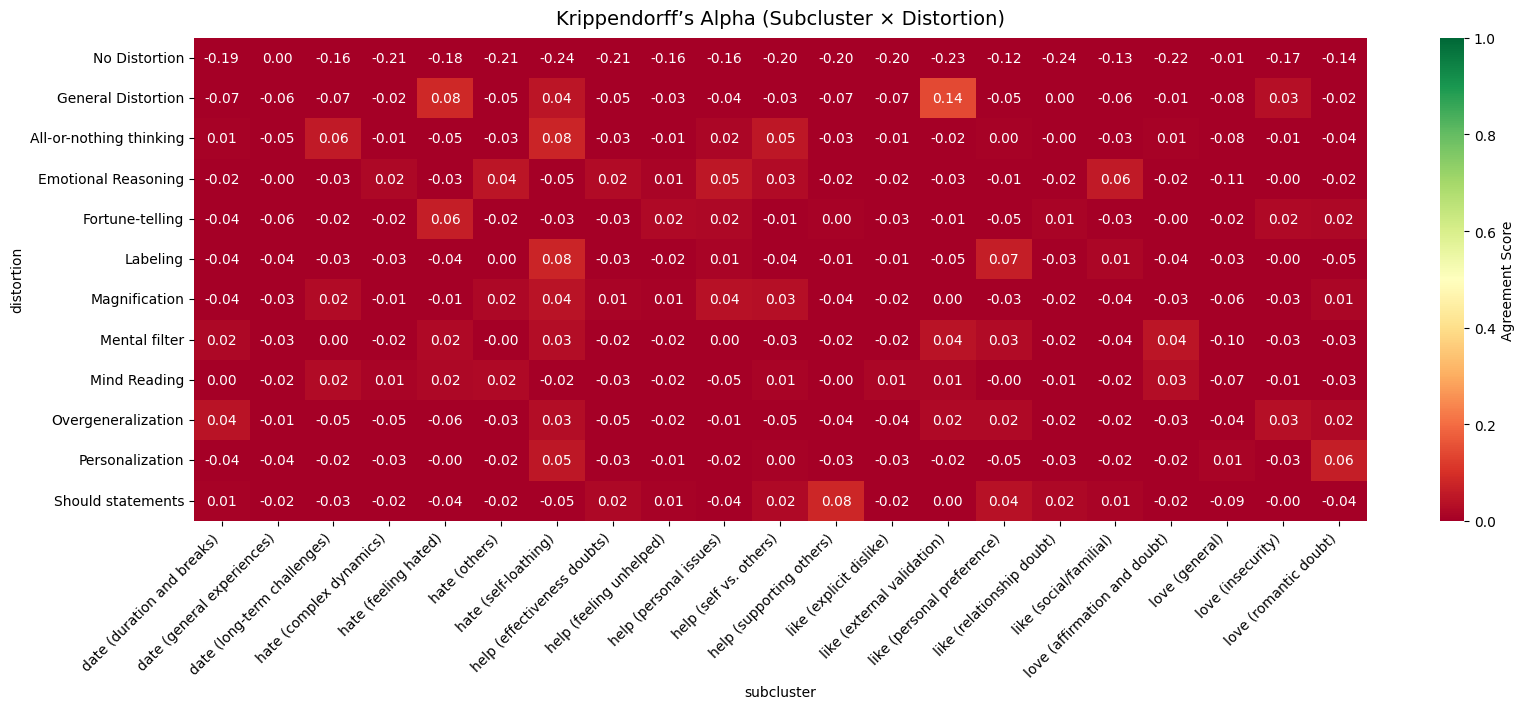

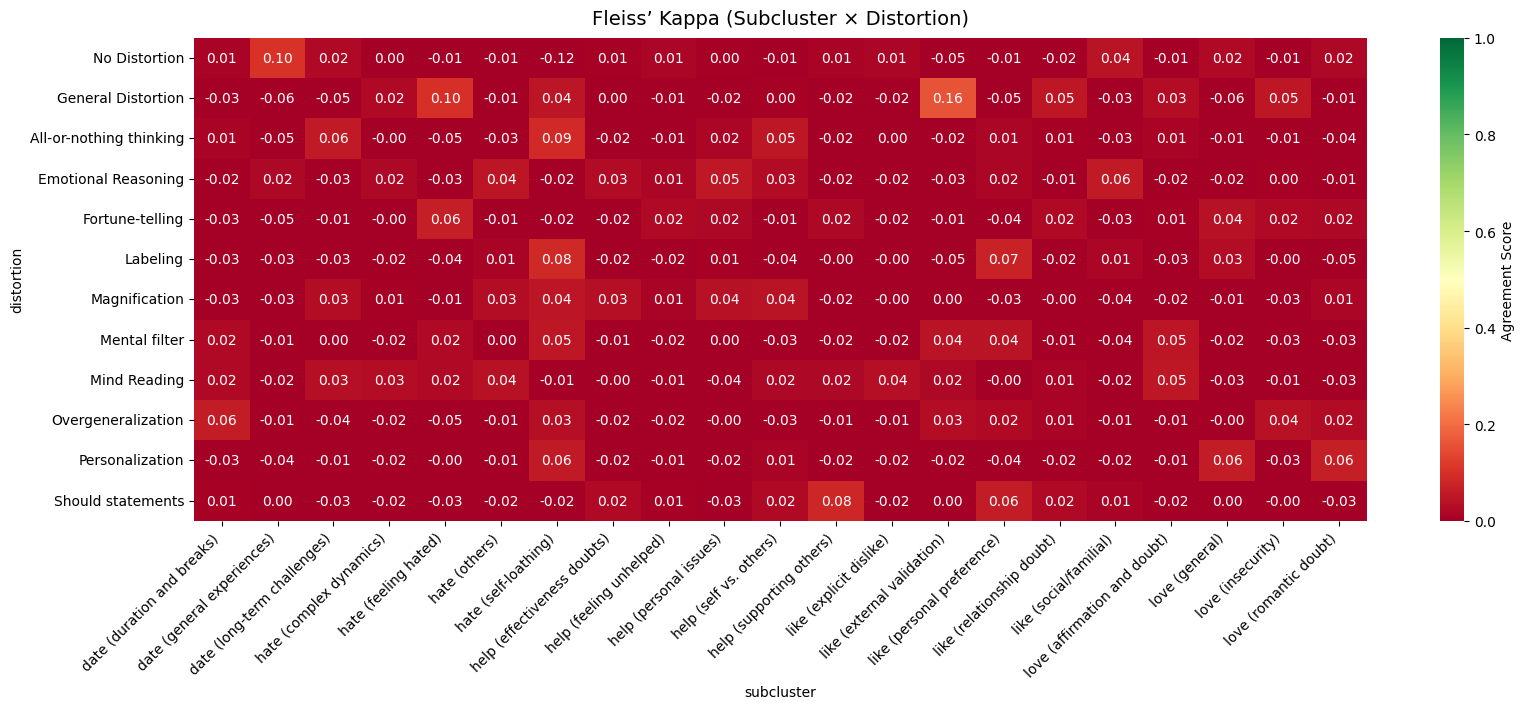

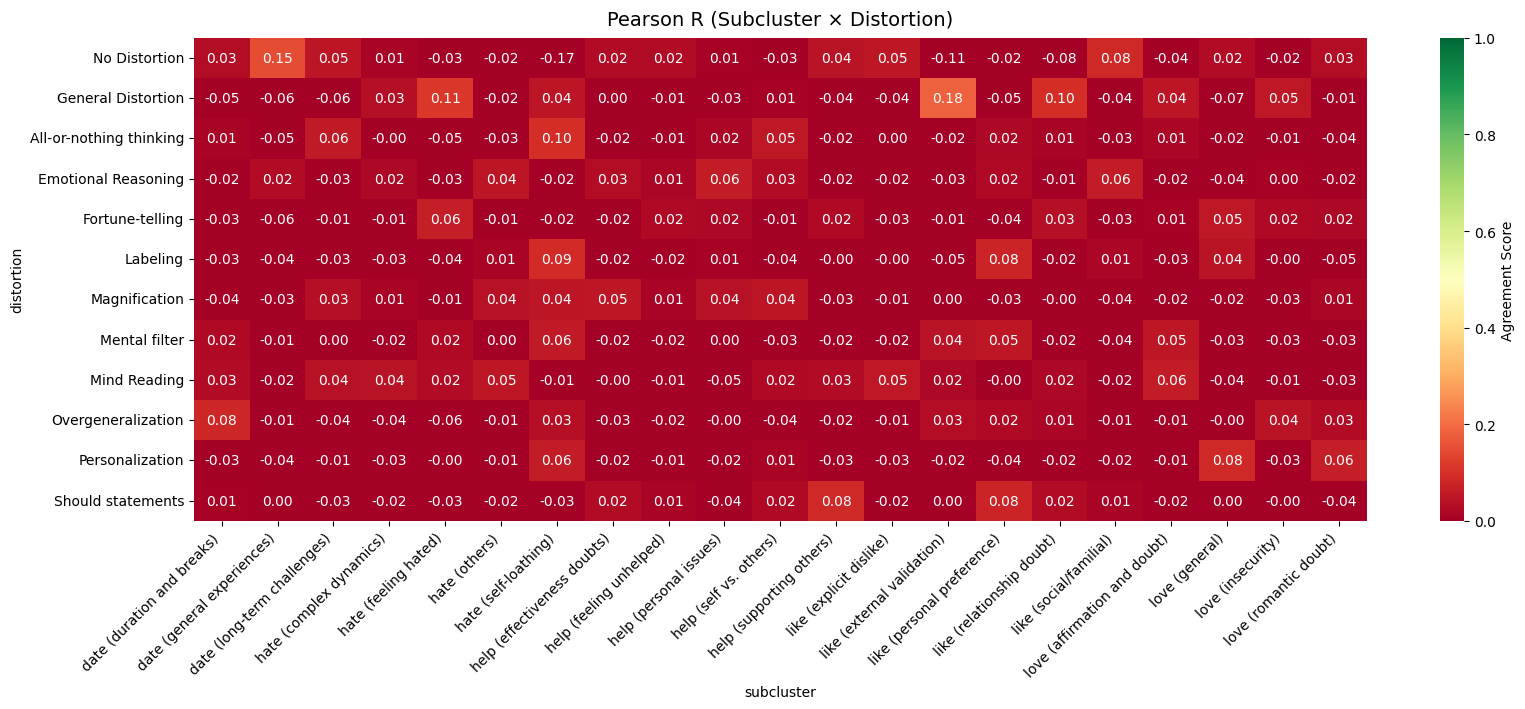

In [20]:
# Custom sorting function
def custom_distortion_sort(distortions):
    return sorted(distortions, key=lambda x: (
        0 if str(x).startswith("No ") else (1 if str(x).startswith("General ") else 2),
        str(x)
    ))

# Heatmap plotting function with correct sorting
def plot_heatmap(matrix, title, vmin=0.0, vmax=1.0, cmap='RdYlGn'):
    # Determine sorting: assumes distortion types are in index (rows), subclusters in columns
    sorted_rows = custom_distortion_sort(matrix.index)   # Fix here
    sorted_cols = sorted(matrix.columns)

    matrix_sorted = matrix.loc[sorted_rows, sorted_cols]  # Apply sorting

    # Plot
    plt.figure(figsize=(len(sorted_cols) * 0.8, len(sorted_rows) * 0.6))
    sns.heatmap(matrix_sorted,
                xticklabels=sorted_cols,
                yticklabels=sorted_rows,
                vmin=vmin,
                vmax=vmax,
                cmap=cmap,
                annot=True,
                fmt=".2f",
                cbar_kws={"label": "Agreement Score"})
    plt.title(title, fontsize=14, pad=10)
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

plot_heatmap(alpha_pivot, "Krippendorff’s Alpha (Subcluster × Distortion)")
plot_heatmap(kappa_pivot, "Fleiss’ Kappa (Subcluster × Distortion)")
plot_heatmap(pearson_pivot, "Pearson R (Subcluster × Distortion)")

 ## Hierarchical Visualization of Relationship Taxonomy

In [28]:
import plotly.graph_objects as go
import networkx as nx

# Define the hierarchical structure as a directed graph
G = nx.DiGraph()

# Layer 1: Root node
G.add_node("Layer 1", layer=0)

# Layer 2: Main clusters (from your existing data)
# Assuming these are derived from the 'relation_cluster_label' or similar
main_clusters = ["Supportive Actions", "Interpersonal Beliefs / Emotions", "Relational Harm"]
for cluster in main_clusters:
    G.add_node(cluster, layer=1)
    G.add_edge("Layer 1", cluster)

# Layer 3: Top 5 relations (from your existing data)
top_relations = ["love", "like", "hate", "date", "help"]
# Add edges from main clusters to relations (adjust mapping as needed)
# This is a simplified mapping, you might need to refine based on your data
mapping = {
    "love": "Interpersonal Beliefs / Emotions",
    "like": "Interpersonal Beliefs / Emotions",
    "hate": "Interpersonal Beliefs / Emotions",
    "date": "Interpersonal Beliefs / Emotions", # Example, adjust if 'date' fits elsewhere
    "help": "Supportive Actions" # Example, adjust if 'help' fits elsewhere
}

for rel in top_relations:
    G.add_node(rel, layer=2)
    if rel in mapping:
        G.add_edge(mapping[rel], rel)
    else:
        # Handle cases where a relation doesn't map to a main cluster
        G.add_edge("Layer 1", rel)


# Layer 4: Subclusters (from your existing data)
subclusters = {
    "love": ["love (general)", "love (insecurity)", "love (affirmation and doubt)", "love (romantic doubt)"],
    "like": ["like (social/familial)", "like (personal preference)", "like (external validation)", "like (relationship doubt)", "like (explicit dislike)"],
    "hate": ["hate (others)", "hate (self-loathing)", "hate (feeling hated)", "hate (complex dynamics)"],
    "date": ["date (general experiences)", "date (long-term challenges)", "date (duration and breaks)"],
    "help": ["help (personal issues)", "help (supporting others)", "help (effectiveness doubts)", "help (self vs. others)", "help (feeling unhelped)"]
}

for parent, children in subclusters.items():
    for child in children:
        G.add_node(child, layer=3)
        G.add_edge(parent, child)

# Get node positions using a layout (e.g., spring layout)
pos = nx.spring_layout(G, k=0.5, iterations=50) # Adjust k and iterations for layout

# Create Edges
edge_x = []
edge_y = []
for edge in G.edges():
    x0, y0 = pos[edge[0]]
    x1, y1 = pos[edge[1]]
    edge_x.append(x0)
    edge_x.append(x1)
    edge_x.append(None)
    edge_y.append(y0)
    edge_y.append(y1)
    edge_y.append(None)

edge_trace = go.Scatter(
    x=edge_x, y=edge_y,
    line=dict(width=0.5, color='#888'),
    hoverinfo='none',
    mode='lines')

# Create Nodes
node_x = []
node_y = []
node_text = []
node_color = []
layer_colors = {0: 'red', 1: 'blue', 2: 'green', 3: 'purple'} # Define colors for each layer

for node in G.nodes():
    x, y = pos[node]
    node_x.append(x)
    node_y.append(y)
    node_text.append(node)
    node_color.append(layer_colors.get(G.nodes[node]['layer'], 'gray')) # Get color based on layer

node_trace = go.Scatter(
    x=node_x, y=node_y, mode='markers+text', hoverinfo='text',
    marker=dict(
        showscale=False,
        colorscale='Viridis',
        color=node_color,
        size=20, # Adjust node size
        colorbar=dict(
            thickness=15,
            title='Node Connections',
            xanchor='left',
            titleside='right'
        ),
        line_width=2),
    text=node_text, # Add node labels
    textposition="bottom center" # Position of labels
)

# Create the figure
fig = go.Figure(data=[edge_trace, node_trace],
             layout=go.Layout(
                title='Interactive Hierarchical Relationship Visualization',
                titlefont_size=16,
                showlegend=False,
                hovermode='closest',
                margin=dict(b=20,l=5,r=5,t=40),
                annotations=[ dict(
                    text="This is an interactive visualization of the relationship hierarchy.<br>Hover over nodes to see labels.",
                    showarrow=False,
                    xref="paper", yref="paper",
                    x=0.005, y=-0.002 ) ],
                xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                yaxis=dict(showgrid=False, zeroline=False, showticklabels=False))
                )

fig.show()